In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import lime.lime_tabular_mod
import matplotlib.pyplot as plt

import importlib
importlib.reload(lime.lime_tabular_mod)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
17,5.1,3.5,1.4,0.3,Iris-setosa
38,4.4,3.0,1.3,0.2,Iris-setosa
96,5.7,2.9,4.2,1.3,Iris-versicolor
15,5.7,4.4,1.5,0.4,Iris-setosa
52,6.9,3.1,4.9,1.5,Iris-versicolor
...,...,...,...,...,...
8,4.4,2.9,1.4,0.2,Iris-setosa
44,5.1,3.8,1.9,0.4,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


In [3]:
labels_column_name = "label"
jackknife_idx = np.random.randint(0, iris_dataset.shape[0])
train_set = iris_dataset.loc[
        iris_dataset.index != jackknife_idx
    ].drop(columns=labels_column_name).values
train_labels = iris_dataset.loc[
        iris_dataset.index != jackknife_idx,
        labels_column_name
    ].values
test_set = iris_dataset.loc[
        iris_dataset.index == jackknife_idx
    ].drop(columns=labels_column_name).values
test_labels = iris_dataset.loc[
        iris_dataset.index == jackknife_idx,
        labels_column_name
    ].values
test_instance = test_set[0]

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)

random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 10)
random_forest.fit(train_set, train_labels)
unique_labels = random_forest.classes_

prediction = random_forest.predict(test_set)
prediction_probabilities = random_forest.predict_proba(test_set)
print(f"Predicted: {prediction}. Probabilities: {prediction_probabilities}")

Predicted: ['Iris-versicolor']. Probabilities: [[0. 1. 0.]]


### Use LIME to explain prediction

,sepal_length,sepal_width,petal_length,petal_width,label
65,6.7,3.1,4.4,1.4,Iris-versicolor


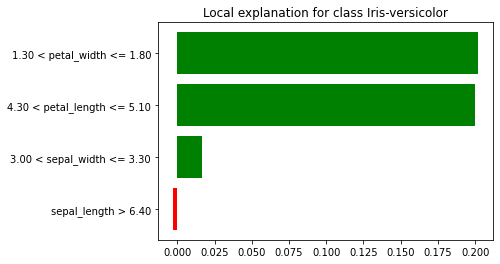

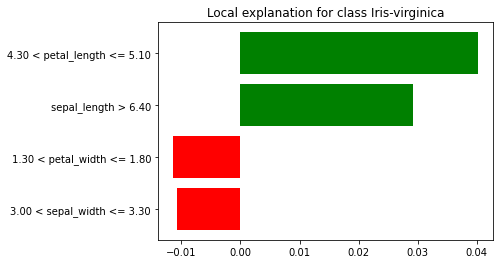

In [19]:
importlib.reload(lime.lime_tabular_mod)
explainer = lime.lime_tabular_mod.LimeTabularExplainerMod(
    train_set,
    feature_names = attributes,
    class_names = unique_labels
)
explanation = explainer.explain_instance(
    test_instance,
    random_forest.predict_proba,
    num_features = 4,
    top_labels = 3
)
for label in explanation.top_labels[:2]:
    _ = explanation.as_pyplot_figure(label)
iris_dataset.loc[
        iris_dataset.index == jackknife_idx
    ]

In [20]:
print(explanation.get_probabilities_for_explained_model())
print(explanation.get_probabilities_for_surrogate_model(order="ordered"))
print(explanation.get_probabilities_for_surrogate_model(normalized=True, order="ordered"))
print(explanation.get_scores_for_surrogate_model(order="ordered"))
print(explanation.get_explanation_fidelity_loss())
print(explanation.prediction_training_loss)


[0. 1. 0.]
[0.2053483534251873, 0.21547877161121687, 0.006171400084254208]
[0.35340849 0.35700686 0.28958464]
[0.004711706051559239, 0.668933369195073, 0.3263549247533678]
0.25234714676247566
0.0912076099258675


In [6]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(3, 0.2142054190770118),
 (2, 0.19218924059844264),
 (1, -0.007512980757746217),
 (0, -0.007214362234376459)]

In [7]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(2, 0.03721710181610464),
 (0, 0.033317934910932094),
 (3, -0.0163410818727581),
 (1, -0.007582977281843536)]

In [8]:
explanation.as_map()

{0: [(2, -0.22940634241454738),
  (3, -0.19786433720425356),
  (0, -0.026103572676555612),
  (1, 0.015095958039589755)],
 2: [(2, 0.03721710181610464),
  (0, 0.033317934910932094),
  (3, -0.0163410818727581),
  (1, -0.007582977281843536)],
 1: [(3, 0.2142054190770118),
  (2, 0.19218924059844264),
  (1, -0.007512980757746217),
  (0, -0.007214362234376459)]}

In [9]:
explainer.discretizer.names

{0: ['sepal_length <= 5.10',
  '5.10 < sepal_length <= 5.80',
  '5.80 < sepal_length <= 6.40',
  'sepal_length > 6.40'],
 1: ['sepal_width <= 2.80',
  '2.80 < sepal_width <= 3.00',
  '3.00 < sepal_width <= 3.30',
  'sepal_width > 3.30'],
 2: ['petal_length <= 1.60',
  '1.60 < petal_length <= 4.30',
  '4.30 < petal_length <= 5.10',
  'petal_length > 5.10'],
 3: ['petal_width <= 0.30',
  '0.30 < petal_width <= 1.30',
  '1.30 < petal_width <= 1.80',
  'petal_width > 1.80']}

In [10]:
explainer.discretizer.maxs


{0: [5.1, 5.8, 6.4, 7.9],
 1: [2.8, 3.0, 3.3, 4.4],
 2: [1.6, 4.3, 5.1, 6.9],
 3: [0.3, 1.3, 1.8, 2.5]}